# CS454 Homework 4
# CNN for MNIST Classification
    
    Author: Furkan CANTÜRK
    Date: 16.12.2019

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12*12*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [27]:
train_batch_size = 64
test_batch_size = 1000
epochs = 20
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 1000
save_model = True

In [15]:
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))])),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),

batch_size=test_batch_size, shuffle=True, **kwargs)

In [28]:
import torch.optim as optim
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [30]:
from IPython.display import display, Math, Latex

print("Weight update formula:")
display(Math(r'w:= w - \eta \sum_{i=1}^{n}\delta Q_{i}(w)/n'))

Weight update formula:


<IPython.core.display.Math object>

In [25]:
def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    avg_loss = 0
    # in training loop:
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

In [17]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss,accuracy

In [29]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch, log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)

# if (save_model):
#     torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 	Loss: 2.323387

Test set: Average loss: 0.1469, Accuracy: 9559/10000 (96%)

Train Epoch: 2 	Loss: 0.129044

Test set: Average loss: 0.0843, Accuracy: 9743/10000 (97%)

Train Epoch: 3 	Loss: 0.097961

Test set: Average loss: 0.0628, Accuracy: 9811/10000 (98%)

Train Epoch: 4 	Loss: 0.113206

Test set: Average loss: 0.0500, Accuracy: 9838/10000 (98%)

Train Epoch: 5 	Loss: 0.091987

Test set: Average loss: 0.0453, Accuracy: 9847/10000 (98%)

Train Epoch: 6 	Loss: 0.024519

Test set: Average loss: 0.0429, Accuracy: 9859/10000 (99%)

Train Epoch: 7 	Loss: 0.030514

Test set: Average loss: 0.0390, Accuracy: 9870/10000 (99%)

Train Epoch: 8 	Loss: 0.043498

Test set: Average loss: 0.0373, Accuracy: 9876/10000 (99%)

Train Epoch: 9 	Loss: 0.020513

Test set: Average loss: 0.0347, Accuracy: 9882/10000 (99%)

Train Epoch: 10 	Loss: 0.055819

Test set: Average loss: 0.0383, Accuracy: 9883/10000 (99%)

Train Epoch: 11 	Loss: 0.054877

Test set: Average loss: 0.0345, Accuracy: 9891

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('mnist_cnn2.pth', map_location=torch.device('cuda')))
# model.eval()

In [31]:
# Confusion matrix from scratch
nb_classes = 10

cm_test = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                cm_test[t.long(), p.long()] += 1

print(cm_test.int())

tensor([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
        [   0, 1127,    2,    1,    1,    0,    2,    0,    2,    0],
        [   1,    1, 1024,    0,    1,    0,    0,    4,    1,    0],
        [   0,    0,    1, 1000,    0,    5,    0,    0,    4,    0],
        [   0,    0,    0,    0,  974,    0,    3,    0,    1,    4],
        [   2,    0,    0,    4,    0,  883,    3,    0,    0,    0],
        [   5,    2,    0,    0,    1,    1,  946,    0,    3,    0],
        [   1,    2,    6,    1,    0,    0,    0, 1014,    2,    2],
        [   2,    0,    2,    0,    0,    0,    0,    0,  970,    0],
        [   1,    0,    0,    1,   10,    3,    0,    1,    3,  990]],
       dtype=torch.int32)


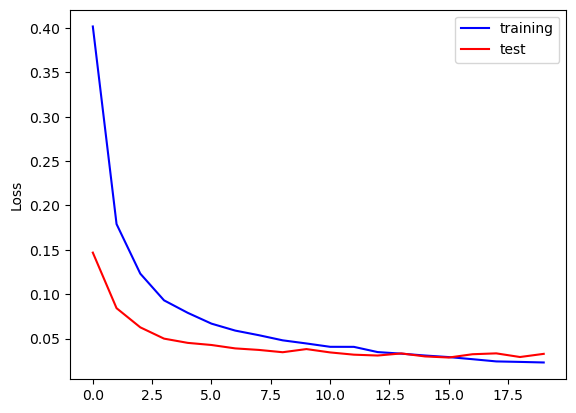

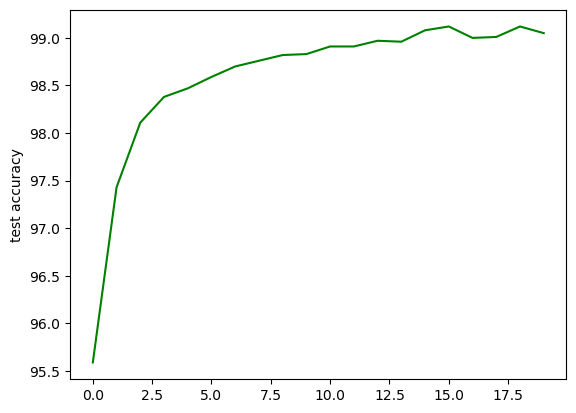

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_losses,'b', label='training')
plt.plot(test_losses,'r', label='test')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(accuracy_list,'g')
plt.ylabel('test accuracy')
plt.show()
